# Ozone pollution in Beijing: a hierarchical linear model

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import pandas as pd
import theano.tensor as tt
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [2]:
# For timing notebook runtime
import time
tic = time.time()

## Load and organize the data

The data are stored in 12 separate files, so we need to load, merge, and group.

In [3]:
aotizhongxin = pd.read_csv('../data/PRSAData/PRSA_Data_Aotizhongxin_20130301-20170228.csv')
changping = pd.read_csv('../data/PRSAData/PRSA_Data_Changping_20130301-20170228.csv')
dingling = pd.read_csv('../data/PRSAData/PRSA_Data_Dingling_20130301-20170228.csv')
dongsi = pd.read_csv('../data/PRSAData/PRSA_Data_Dongsi_20130301-20170228.csv')
guanyan = pd.read_csv('../data/PRSAData/PRSA_Data_Guanyuan_20130301-20170228.csv')
gucheng = pd.read_csv('../data/PRSAData/PRSA_Data_Gucheng_20130301-20170228.csv')
huairou = pd.read_csv('../data/PRSAData/PRSA_Data_Huairou_20130301-20170228.csv')
nongzhanguan = pd.read_csv('../data/PRSAData/PRSA_Data_Nongzhanguan_20130301-20170228.csv')
shunyi = pd.read_csv('../data/PRSAData/PRSA_Data_Shunyi_20130301-20170228.csv')
tiantan = pd.read_csv('../data/PRSAData/PRSA_Data_Tiantan_20130301-20170228.csv')
wanliu = pd.read_csv('../data/PRSAData/PRSA_Data_Wanliu_20130301-20170228.csv')
wanshouxigong = pd.read_csv('../data/PRSAData/PRSA_Data_Wanshouxigong_20130301-20170228.csv')

Make a date column for each so that we can group by date:

In [4]:
aotizhongxin['date'] = aotizhongxin.year.astype(str) + '-' + aotizhongxin.month.astype(str) + '-' + aotizhongxin.day.astype(str)
changping['date'] = changping.year.astype(str) + '-' + changping.month.astype(str) + '-' + changping.day.astype(str)
dingling['date'] = dingling.year.astype(str) + '-' + dingling.month.astype(str) + '-' + dingling.day.astype(str)
dongsi['date'] = dongsi.year.astype(str) + '-' + dongsi.month.astype(str) + '-' + dongsi.day.astype(str)
guanyan['date'] = guanyan.year.astype(str) + '-' + guanyan.month.astype(str) + '-' + guanyan.day.astype(str)
gucheng['date'] = gucheng.year.astype(str) + '-' + gucheng.month.astype(str) + '-' + gucheng.day.astype(str)
huairou['date'] = huairou.year.astype(str) + '-' + huairou.month.astype(str) + '-' + huairou.day.astype(str)
nongzhanguan['date'] = nongzhanguan.year.astype(str) + '-' + nongzhanguan.month.astype(str) + '-' + nongzhanguan.day.astype(str)
shunyi['date'] = shunyi.year.astype(str) + '-' + shunyi.month.astype(str) + '-' + shunyi.day.astype(str)
tiantan['date'] = tiantan.year.astype(str) + '-' + tiantan.month.astype(str) + '-' + tiantan.day.astype(str)
wanliu['date'] = wanliu.year.astype(str) + '-' + wanliu.month.astype(str) + '-' + wanliu.day.astype(str)
wanshouxigong['date'] = wanshouxigong.year.astype(str) + '-' + wanshouxigong.month.astype(str) + '-' + wanshouxigong.day.astype(str)

Concatenate the tables and group by date and station, then create a log ozone column:

In [5]:
fulldata = pd.concat([aotizhongxin, changping, dingling, dongsi, guanyan, gucheng, huairou, nongzhanguan, shunyi, tiantan, wanliu, wanshouxigong])

In [6]:
dailies = fulldata.groupby(by=['date', 'station']).max()
dailies['log_ozone'] = np.log(dailies['O3'])
dailies

No  year  month  day  hour  PM2.5   PM10   SO2  \
date      station                                                            
2013-10-1 Aotizhongxin    5160  2013     10    1    23  240.0  264.0  23.0   
          Changping       5160  2013     10    1    23  174.0  166.0   8.0   
          Dingling        5160  2013     10    1    23    NaN    NaN   NaN   
          Dongsi          5160  2013     10    1    23  220.0  216.0  22.0   
          Guanyuan        5160  2013     10    1    23  229.0  226.0  11.0   
...                        ...   ...    ...  ...   ...    ...    ...   ...   
2017-2-9  Nongzhanguan   34608  2017      2    9    23    9.0  134.0   6.0   
          Shunyi         34608  2017      2    9    23    8.0   55.0   2.0   
          Tiantan        34608  2017      2    9    23   14.0   50.0   2.0   
          Wanliu         34608  2017      2    9    23    8.0  107.0   5.0   
          Wanshouxigong  34608  2017      2    9    23   11.0   38.0   4.0   

                           NO2      CO       O3  TEMP    PRES  DEWP  RAIN  \
date      station                                                           
2013-10-1 Aotizhongxin   115.0  2200.0  68.7582  22.3  1016.2  17.4   0.8   
          Changping       64.0   800.0  91.2492  23.0  1013.0  16.8   1.0   
          Dingling         NaN     NaN      NaN  23.0  1013.0  16.8   1.0   
          Dongsi         119.0  2400.0  74.1132  21.7  1017.8  17.7   6.5   
          Guanyuan        89.0  2400.0  77.9688  22.3  1016.2  17.4   0.8   
...                        ...     ...      ...   ...     ...   ...   ...   
2017-2-9  Nongzhanguan    28.0   500.0  87.0000   2.8  1027.9 -19.8   0.0   
          Shunyi          12.0   100.0  88.0000   1.9  1028.5 -19.5   0.0   
          Tiantan         30.0   500.0  85.0000   2.8  1027.9 -19.8   0.0   
          Wanliu          19.0   400.0  97.0000   2.9  1026.6 -19.9   0.0   
          Wanshouxigong   20.0   400.0  78.0000   2.8  1027.9 -19.8   0.0   

                         WSPM  log_ozone  
date      station                         
2013-10-1 Aotizhongxin    1.7   4.230596  
          Changping       2.2   4.513594  
          Dingling        2.2        NaN  
          Dongsi          4.2   4.305594  
          Guanyuan        1.7   4.356309  
...                       ...        ...  
2017-2-9  Nongzhanguan    5.8   4.465908  
          Shunyi          7.8   4.477337  
          Tiantan         5.8   4.442651  
          Wanliu          5.6   4.574711  
          Wanshouxigong   5.8   4.356709  

[17532 rows x 17 columns]

In [7]:
# Need an integer station id for indexing
dailies = dailies.reset_index()
dailies['station_id'] = OrdinalEncoder().fit_transform(dailies[['station']]).astype(np.int64)
dailies

,date,station,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,log_ozone,station_id
0,2013-10-1,Aotizhongxin,5160,2013,10,1,23,240.0,264.0,23.0,115.0,2200.0,68.7582,22.3,1016.2,17.4,0.8,1.7,4.230596,0
1,2013-10-1,Changping,5160,2013,10,1,23,174.0,166.0,8.0,64.0,800.0,91.2492,23.0,1013.0,16.8,1.0,2.2,4.513594,1
2,2013-10-1,Dingling,5160,2013,10,1,23,NaN,NaN,NaN,NaN,NaN,NaN,23.0,1013.0,16.8,1.0,2.2,NaN,2
3,2013-10-1,Dongsi,5160,2013,10,1,23,220.0,216.0,22.0,119.0,2400.0,74.1132,21.7,1017.8,17.7,6.5,4.2,4.305594,3
4,2013-10-1,Guanyuan,5160,2013,10,1,23,229.0,226.0,11.0,89.0,2400.0,77.9688,22.3,1016.2,17.4,0.8,1.7,4.356309,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17527,2017-2-9,Nongzhanguan,34608,2017,2,9,23,9.0,134.0,6.0,28.0,500.0,87.0000,2.8,1027.9,-19.8,0.0,5.8,4.465908,7
17528,2017-2-9,Shunyi,34608,2017,2,9,23,8.0,55.0,2.0,12.0,100.0,88.0000,1.9,1028.5,-19.5,0.0,7.8,4.477337,8
17529,2017-2-9,Tiantan,34608,2017,2,9,23,14.0,50.0,2.0,30.0,500.0,85.0000,2.8,1027.9,-19.8,0.0,5.8,4.442651,9
17530,2017-2-9,Wanliu,34608,2017,2,9,23,8.0,107.0,5.0,19.0,400.0,97.0000,2.9,1026.6,-19.9,0.0,5.6,4.574711,10


## Building some linear models

In [8]:
# There are a few NAs here, but not many
data = dailies.dropna()
# Use this instead to drop about half the data to make models fit faster
# data = dailies[dailies['date'] < '2015-1-1'].dropna()

In [9]:
# First pass: pool all the data and fit a single linear model
with pm.Model() as pooled_model:
    alpha = pm.Normal('alpha', 0, 2)
    beta = pm.Normal('beta', 0, 0.1)
    sigma = pm.HalfCauchy('sigma', 1)
    
    theta = alpha + beta * data['TEMP']
    
    y_ = pm.Normal('y', mu=theta, sigma = sigma, observed = data['log_ozone'])
    pooled_trace = pm.sample(1000, chains = 4, cores = 4)
    pooled_summary = az.summary(pooled_trace)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8920152107605388, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875140012621596, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8903984803605011, but should be close to 0.8. Try to increase the number of tuning steps.


In [10]:
pooled_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.454,0.009,3.435,3.470,0.0,0.0,1607.0,1679.0,1.0
beta,0.054,0.000,0.053,0.055,0.0,0.0,1601.0,1799.0,1.0
sigma,0.612,0.003,0.606,0.619,0.0,0.0,2517.0,2696.0,1.0


In [11]:
# Varying intercepts model
with pm.Model() as vi_model:
    mu = pm.Normal('mu', 0, 2)
    tau = pm.HalfCauchy('tau', 1)
    sigma = pm.HalfCauchy('sigma', 1)
    
    alpha = pm.Normal('alpha', mu, tau, shape = 12)
    beta = pm.Normal('beta', 0, 0.1)
    
    theta = alpha[data['station_id']] + beta * data['TEMP']
    
    y_ = pm.Normal('y', mu=theta, sigma = sigma, observed = data['log_ozone'])
    vi_trace = pm.sample(1000, chains=4, cores=4, tune=1000)
    vi_summary = az.summary(vi_trace)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.9362715151516091, but should be close to 0.8. Try to increase the number of tuning steps.


In [12]:
vi_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3.451,0.028,3.397,3.504,0.0,0.0,3711.0,2495.0,1.0
alpha[0],3.422,0.018,3.388,3.456,0.0,0.0,3811.0,3607.0,1.0
alpha[1],3.411,0.018,3.378,3.444,0.0,0.0,4261.0,3105.0,1.0
alpha[2],3.573,0.018,3.542,3.609,0.0,0.0,4044.0,2885.0,1.0
alpha[3],3.456,0.018,3.424,3.491,0.0,0.0,4987.0,3282.0,1.0
alpha[4],3.390,0.018,3.358,3.424,0.0,0.0,4384.0,2857.0,1.0
alpha[5],3.462,0.018,3.426,3.494,0.0,0.0,4945.0,2743.0,1.0
alpha[6],3.525,0.017,3.493,3.557,0.0,0.0,4377.0,3279.0,1.0
alpha[7],3.506,0.017,3.473,3.537,0.0,0.0,3738.0,3121.0,1.0
alpha[8],3.488,0.018,3.453,3.521,0.0,0.0,4983.0,2995.0,1.0


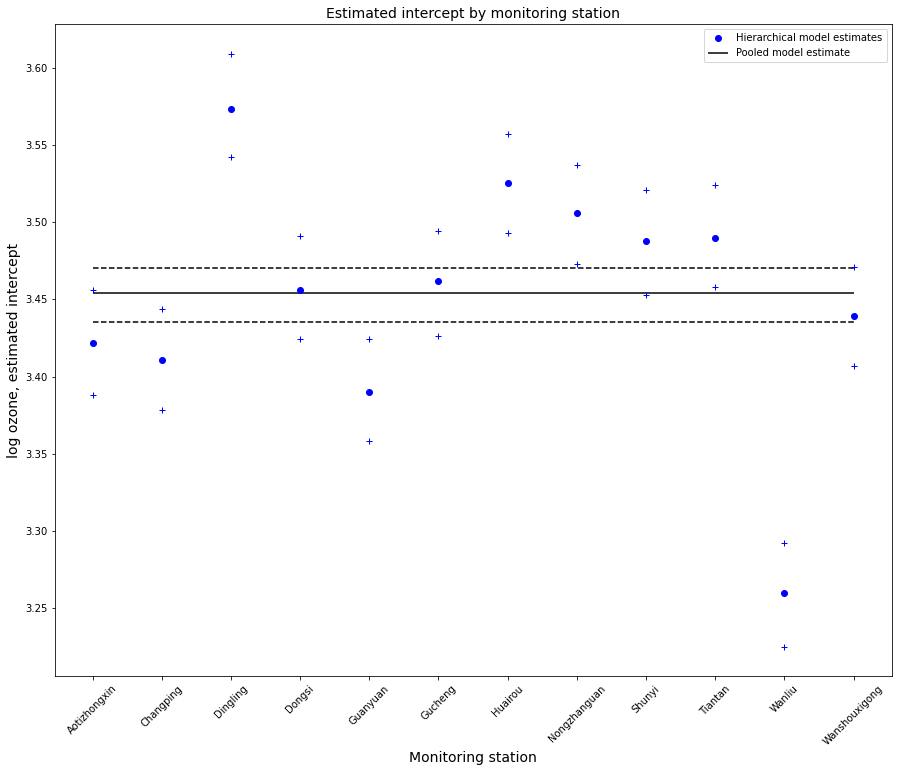

In [13]:
# Compare varying intercepts to the pooled estimate
plt.figure(figsize=(15, 12))
plt.plot(np.arange(0, 12), vi_summary['mean'][1:13], 'o', color = 'blue', label = 'Hierarchical model estimates')
plt.plot(np.arange(0, 12), vi_summary['hdi_3%'][1:13], '+', color = 'blue')
plt.plot(np.arange(0, 12), vi_summary['hdi_97%'][1:13], '+', color = 'blue')
plt.hlines(y=pooled_summary['mean'][0], xmin=0, xmax=11, color = 'black', label = 'Pooled model estimate')
plt.hlines(y=pooled_summary['hdi_3%'][0], xmin=0, xmax=11, color = 'black', ls='--')
plt.hlines(y=pooled_summary['hdi_97%'][0], xmin=0, xmax=11, color = 'black', ls='--')
plt.legend()
plt.xlabel('Monitoring station', size = 14)
plt.ylabel('log ozone, estimated intercept', size=14)
plt.yticks(size=10)
plt.xticks(np.arange(12), labels = sorted(set(dailies['station'])), size=10, rotation = 45)
plt.title('Estimated intercept by monitoring station', size=14)
plt.show()

In [14]:
# Unpooled model -- 12 independent regressions. For comparison.
with pm.Model() as unpooled_model:
    sigma = pm.HalfCauchy('sigma', 1)
    
    alpha = pm.Normal('alpha', 0, 3, shape = 12)
    beta = pm.Normal('beta', 0, 1, shape = 12)
    
    theta = alpha[data['station_id']] + beta[data['station_id']] * data['TEMP']
    
    y_ = pm.Normal('y', mu=theta, sigma = sigma, observed = data['log_ozone'])
    unpooled_trace = pm.sample(1000, chains=4, cores=4, tune=1000)
    unpooled_summary = az.summary(unpooled_trace)
    unpooled_alphas = az.summary(unpooled_trace, var_names = ['alpha'])
    unpooled_betas = az.summary(unpooled_trace, var_names = ['beta'])

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


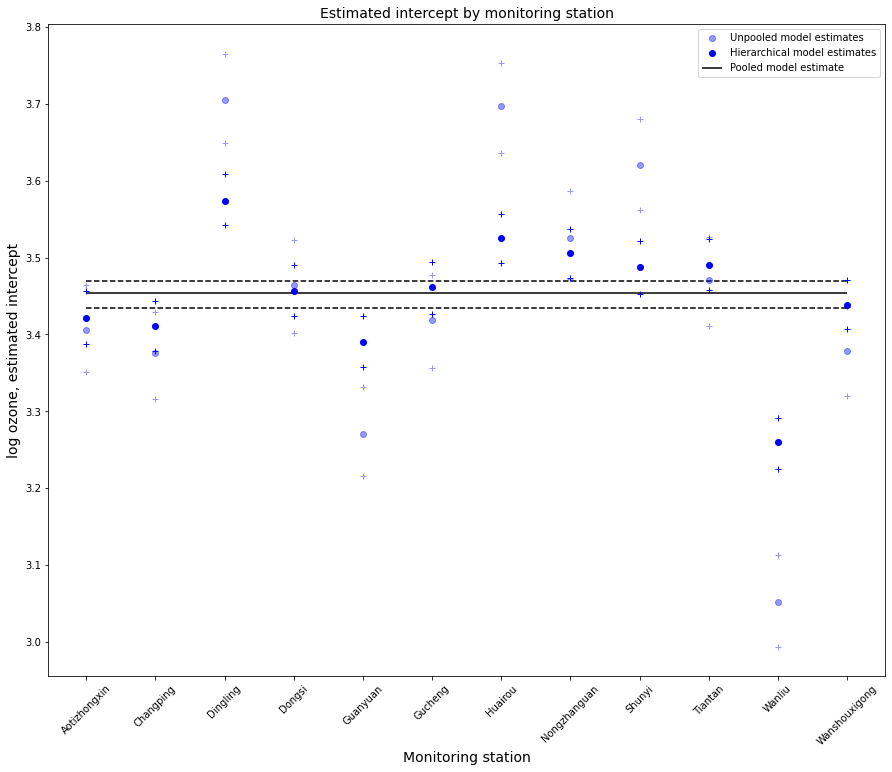

In [15]:
# Visualize shrinkage by comparing unpooled intercepts to pooled intercepts.
plt.figure(figsize=(15, 12))
plt.plot(np.arange(0, 12), unpooled_summary['mean'][0:12], 'o', color = 'blue', alpha = 0.4, label = 'Unpooled model estimates')
plt.plot(np.arange(0, 12), unpooled_summary['hdi_3%'][0:12], '+', color = 'blue', alpha = 0.4)
plt.plot(np.arange(0, 12), unpooled_summary['hdi_97%'][0:12], '+', color = 'blue', alpha = 0.4)
plt.plot(np.arange(0, 12), vi_summary['mean'][1:13], 'o', color = 'blue', label = 'Hierarchical model estimates')
plt.plot(np.arange(0, 12), vi_summary['hdi_3%'][1:13], '+', color = 'blue')
plt.plot(np.arange(0, 12), vi_summary['hdi_97%'][1:13], '+', color = 'blue')
plt.hlines(y=pooled_summary['mean'][0], xmin=0, xmax=11, color = 'black', label = 'Pooled model estimate')
plt.hlines(y=pooled_summary['hdi_3%'][0], xmin=0, xmax=11, color = 'black', ls='--')
plt.hlines(y=pooled_summary['hdi_97%'][0], xmin=0, xmax=11, color = 'black', ls='--')
plt.legend()
plt.xlabel('Monitoring station', size = 14)
plt.ylabel('log ozone, estimated intercept', size=14)
plt.yticks(size=10)
plt.xticks(np.arange(12), labels = sorted(set(dailies['station'])), size=10, rotation = 45)
plt.title('Estimated intercept by monitoring station', size=14)
plt.show()


In [16]:
# Varying slopes model
with pm.Model() as vs_model:
    mu_a = pm.Normal('mu_a', 0, 2)
    tau_a = pm.HalfCauchy('tau_a', 1)
    mu_b = pm.Normal('mu_b', 0, 0.1)
    tau_b = pm.HalfCauchy('tau_b', 1)
    sigma = pm.HalfCauchy('sigma', 1)
    
    alpha = pm.Normal('alpha', mu_a, tau_a, shape = 12)
    beta = pm.Normal('beta', mu_b, tau_b, shape = 12)
    
    theta = alpha[data['station_id']] + beta[data['station_id']] * data['TEMP']
    
    y_ = pm.Normal('y', mu=theta, sigma = sigma, observed = data['log_ozone'])
    vs_trace = pm.sample(1000, chains=4, cores=4, tune=1000)
    vs_summary = az.summary(vs_trace)
    vs_alphas = az.summary(vs_trace, var_names = ['alpha'])
    vs_betas = az.summary(vs_trace, var_names = ['beta'])

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma, tau_b, mu_b, tau_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.


In [17]:
vs_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,3.447,0.061,3.333,3.569,0.001,0.001,4848.0,2533.0,1.0
mu_b,0.054,0.002,0.051,0.058,0.000,0.000,5279.0,2788.0,1.0
alpha[0],3.408,0.030,3.354,3.466,0.000,0.000,6126.0,3042.0,1.0
alpha[1],3.380,0.030,3.326,3.438,0.000,0.000,6344.0,3051.0,1.0
alpha[2],3.690,0.031,3.634,3.748,0.000,0.000,6067.0,2992.0,1.0
alpha[3],3.464,0.030,3.408,3.520,0.000,0.000,6788.0,3113.0,1.0
alpha[4],3.284,0.031,3.225,3.342,0.000,0.000,6794.0,3158.0,1.0
alpha[5],3.423,0.031,3.367,3.483,0.000,0.000,6670.0,3039.0,1.0
alpha[6],3.680,0.031,3.619,3.734,0.000,0.000,5731.0,2938.0,1.0
alpha[7],3.523,0.029,3.467,3.578,0.000,0.000,7282.0,2999.0,1.0


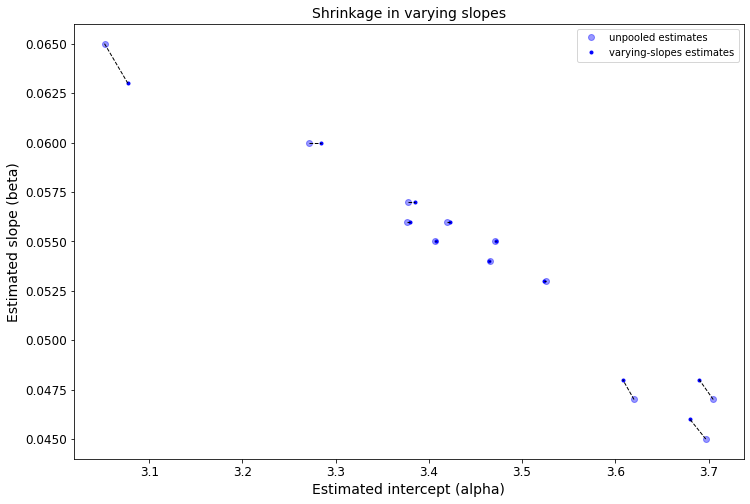

In [18]:
# Visualize shrinkage from the varying slopes model
plt.figure(figsize=(12, 8))
plt.plot(unpooled_alphas['mean'], unpooled_betas['mean'], 'o', color = 'blue', alpha = 0.4, label = 'unpooled estimates')
plt.plot(vs_alphas['mean'], vs_betas['mean'], '.', color = 'blue', alpha = 1, label = 'varying-slopes estimates')
plt.title('Shrinkage in varying slopes', size = 14)
plt.xlabel('Estimated intercept (alpha)', size = 14)
plt.ylabel('Estimated slope (beta)', size = 14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.legend()
for i in range(12):
    plt.plot([unpooled_alphas['mean'][i], vs_alphas['mean'][i]], [unpooled_betas['mean'][i], vs_betas['mean'][i]], ls='--', lw=1, color = 'black')
plt.show()

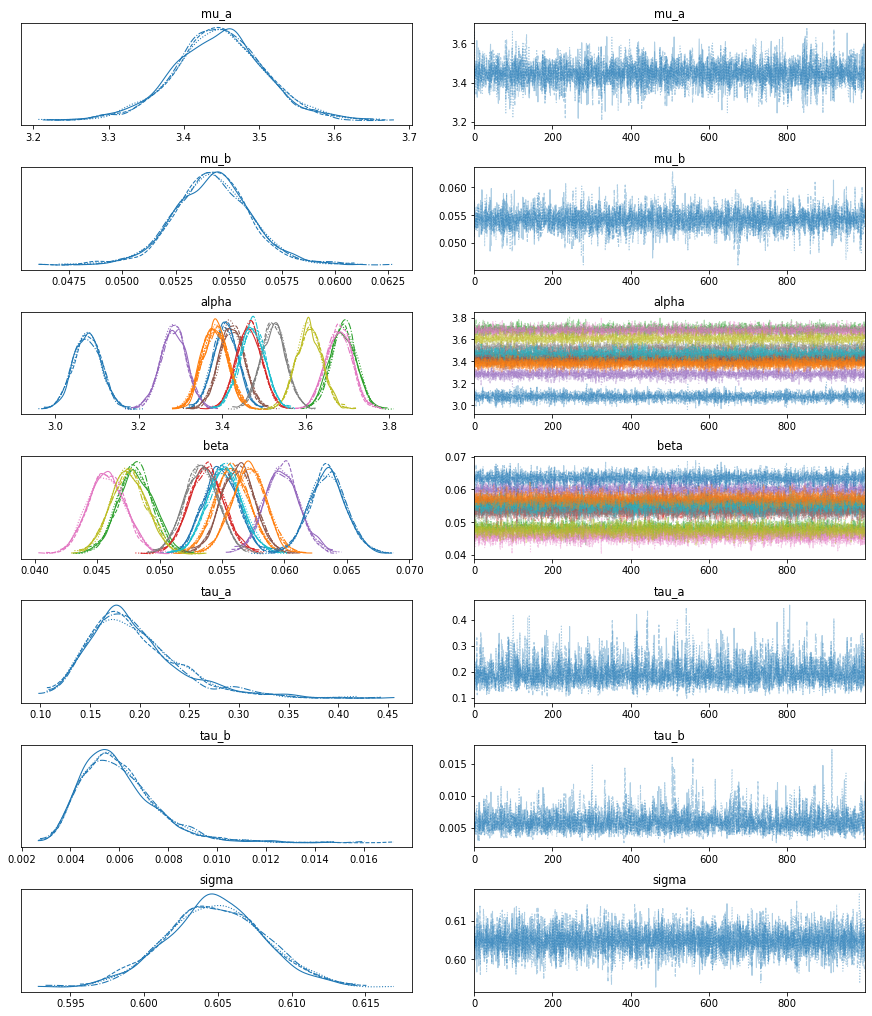

In [19]:
# Make a traceplot -- first clue about correlated slopes and intercepts
with vs_model:
    az.plot_trace(vs_trace)

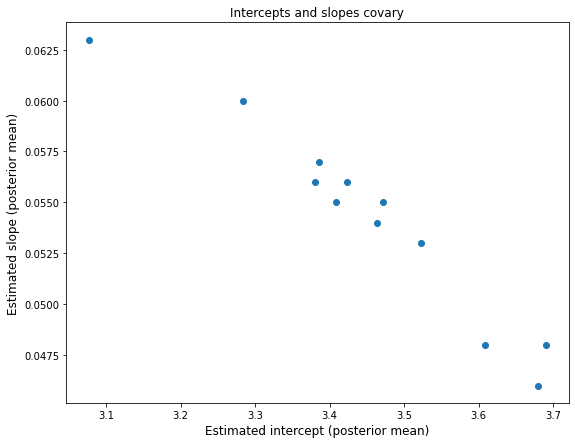

In [20]:
# Visualize correlation between estimated slopes and intercepts
intercepts = vs_summary.iloc[2:14]
slopes = vs_summary.iloc[14:26]
plt.figure(figsize=(9,7))
plt.plot(vs_alphas['mean'], vs_betas['mean'], 'o')
plt.xlabel('Estimated intercept (posterior mean)', size=12)
plt.ylabel('Estimated slope (posterior mean)', size=12)
plt.title('Intercepts and slopes covary')
plt.show()

In [21]:
# Model with correlations -- centered parameterization. Doesn't work well.
with pm.Model() as cov_model:
    mu_a = pm.Normal('mu_a', 0, 2)
    mu_b = pm.Normal('mu_b', 0, 0.1)
    sigma = pm.HalfCauchy('sigma', 1)
    
    sd_dist = pm.HalfCauchy.dist(1)
        
    chol, corr, sd = pm.LKJCholeskyCov('chol_cov', eta = 2, n = 2, sd_dist = sd_dist, compute_corr = True)
    
    coeff = pm.MvNormal('coeffs', mu = tt.stack([mu_a, mu_b]), chol=chol, shape=(12, 2))
    alpha = pm.Deterministic('alpha', coeff[:, 0])
    beta = pm.Deterministic('beta', coeff[:, 1])
    
    theta = alpha[data['station_id']] + beta[data['station_id']] * data['TEMP']
    
    y_ = pm.Normal('y', mu=theta, sigma = sigma, observed = data['log_ozone'])
    cov_trace = pm.sample(500, chains=4, cores=4, tune=500)
    cov_summary = az.summary(cov_trace, var_names = ['~coeffs'])

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeffs, chol_cov, sigma, mu_b, mu_a]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 285 seconds.
The acceptance probability does not match the target. It is 0.9887586824909174, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9363391645650222, but should be close to 0.8. Try to increase the number of tuning steps.
There were 283 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9798446951301912, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/stats/diagnostics.

In [22]:
cov_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,3.449,0.055,3.345,3.551,0.001,0.001,1393.0,1018.0,1.00
mu_b,0.054,0.002,0.051,0.058,0.000,0.000,1371.0,1053.0,1.00
sigma,0.605,0.003,0.599,0.611,0.000,0.000,2675.0,1366.0,1.01
chol_cov[0],0.180,0.040,0.112,0.254,0.002,0.001,498.0,567.0,1.01
chol_cov[1],-0.005,0.001,-0.008,-0.003,0.000,0.000,498.0,916.0,1.01
chol_cov[2],0.002,0.001,0.001,0.003,0.000,0.000,201.0,974.0,1.03
chol_cov_stds[0],0.180,0.040,0.112,0.254,0.002,0.001,498.0,567.0,1.01
chol_cov_stds[1],0.006,0.001,0.003,0.008,0.000,0.000,520.0,911.0,1.01
"chol_cov_corr[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,NaN
"chol_cov_corr[0,1]",-0.914,0.074,-0.994,-0.781,0.003,0.002,452.0,899.0,1.01


In [23]:
# Model with correlations -- noncentered parameterization.
with pm.Model() as noncentered_model:
    mu_a = pm.Normal('mu_a', 0, 2)
    mu_b = pm.Normal('mu_b', 0, 0.1)
    sigma = pm.HalfCauchy('sigma', 1)
    
    sd_dist = pm.HalfCauchy.dist(1)
        
    chol, corr, sd = pm.LKJCholeskyCov('chol', eta = 2, n = 2, sd_dist = sd_dist, compute_corr = True)
    z = pm.Normal('z', 0, 1, shape = (2, 12))
    coeff = pm.Deterministic('coeff', tt.stack([mu_a, mu_b]) + tt.dot(chol, z).T)
    alpha = pm.Deterministic('alpha', coeff[:, 0])
    beta = pm.Deterministic('beta', coeff[:, 1])
    
    theta = alpha[data['station_id']] + beta[data['station_id']] * data['TEMP']
    
    y_ = pm.Normal('y', mu=theta, sigma = sigma, observed = data['log_ozone'])
    noncentered_trace = pm.sample(500, chains=4, cores=4, tune=500, target_accept = 0.9)
    noncentered_summary = az.summary(noncentered_trace, var_names = ['~z', '~coeff'])
    nc_alphas = az.summary(noncentered_trace, var_names = ['alpha'])
    nc_betas = az.summary(noncentered_trace, var_names = ['beta'])

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, chol, sigma, mu_b, mu_a]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 273 seconds.
The acceptance probability does not match the target. It is 0.9685486905987073, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9952143081758236, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


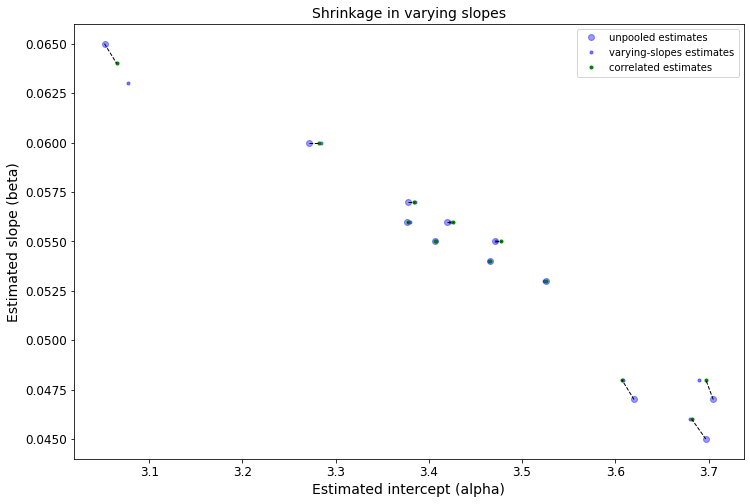

In [24]:
# Visualize shrinking from the varying-slopes model with correlations
plt.figure(figsize=(12, 8))
plt.plot(unpooled_alphas['mean'], unpooled_betas['mean'], 'o', color = 'blue', alpha = 0.4, label = 'unpooled estimates')
plt.plot(vs_alphas['mean'], vs_betas['mean'], '.', color = 'blue', alpha = 0.5, label = 'varying-slopes estimates')
plt.plot(nc_alphas['mean'], nc_betas['mean'], '.', color = 'green', alpha = 1, label = 'correlated estimates')
plt.title('Shrinkage in varying slopes', size = 14)
plt.xlabel('Estimated intercept (alpha)', size = 14)
plt.ylabel('Estimated slope (beta)', size = 14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.legend()
for i in range(12):
    plt.plot([unpooled_alphas['mean'][i], nc_alphas['mean'][i]], [unpooled_betas['mean'][i], nc_betas['mean'][i]], ls='--', lw=1, color = 'black')
plt.show()

In [25]:
# Run PSIS-LOO model comparison on the four models
az.compare({'pooled':pooled_trace, 'varying intercepts':vi_trace, 'varying slopes':vs_trace, 'correlations':noncentered_trace})

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/data/io_pymc3.py:9

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
correlations,0,-15557.282395,29.582499,0.000000,0.810606,190.134514,0.000000,False,log
varying slopes,1,-15557.763317,29.811255,0.480922,0.000000,190.123183,0.839399,False,log
varying intercepts,2,-15629.219938,16.833260,71.937543,0.000000,189.535099,13.847153,False,log
pooled,3,-15757.570225,6.487117,200.287830,0.189394,190.455650,26.983271,False,log


In [26]:
toc = time.time()
print('Notebook ran in', round(toc - tic), 'seconds after imports.')
print('PyMC3 version', pm.__version__)
print('ArviZ version', az.__version__)

Notebook ran in 821 seconds after imports.
PyMC3 version 3.11.1
ArviZ version 0.11.2
